In [1]:
import numpy as np
import pandas as pd
import skeliner as sk

from pywarper.surface import fit_sac_surface, build_mapping
from pywarper.arbor import warp_arbor, get_zprofile, get_xyprofile
from pywarper.stats import get_convex_hull, get_hull_centroid, get_xy_center_of_mass


In [2]:
def read_ChAT(filename):
    
    df = pd.read_csv(filename, comment='#', sep=r'\s+')
    x = df["X"].values.astype(float)
    y = df["Slice"].values.astype(float)
    z = df["Y"].values.astype(float)

    x = x + 1
    z = z + 1

    return x, y ,z

# data from Sümbül et al. 2014
# https://github.com/uygarsumbul/rgc
chat_top = read_ChAT("../tests/data/Image013-009_01_ChAT-TopBand-Mike.txt") # should be the off sac layer
chat_bottom = read_ChAT("../tests/data/Image013-009_01_ChAT-BottomBand-Mike.txt") # should be the on sac layer
# but the image can be flipped
if chat_top[2].mean() > chat_bottom[2].mean():
    off_sac = chat_top
    on_sac = chat_bottom
else:
    off_sac = chat_bottom
    on_sac = chat_top

# nodes += 1 # to match the matlab code
skel = sk.io.load_swc("../tests/data/Image013-009_01_raw_latest_Uygar.swc")

In [3]:
# Fit surfaces with pygridfit under the hood
off_sac_surface, xgridmax, ygridmax = fit_sac_surface(x=off_sac[0], y=off_sac[1], z=off_sac[2], smoothness=15)
on_sac_surface,  xgridmin, ygridmin = fit_sac_surface(x=on_sac[0], y=on_sac[1], z=on_sac[2], smoothness=15)

In [4]:
# fit quasi-conformally mapping
arbor_boundaries = np.array([skel.nodes[:, 0].min(), skel.nodes[:, 0].max(), skel.nodes[:, 1].min(), skel.nodes[:, 1].max()])
surface_mapping = build_mapping(on_sac_surface, off_sac_surface, arbor_boundaries, conformal_jump=2, verbose=True)

Mapping ON (min) surface …
Completed in 0.83 seconds.
Mapping OFF (max) surface …
Completed in 0.86 seconds.


In [5]:
# warp the arbor

# up until this point, all computation were done in the original coordinate system
# only the warped arbor will be in physical units, if we provide the voxel resolution
# warped_arbor = warp_arbor(nodes, edges, radii, surface_mapping, voxel_resolution=[0.4, 0.4, 0.5], conformal_jump=2, verbose=True)
# warped_nodes = np.asarray(warped_arbor["nodes"])

warped_arbor = warp_arbor(skel, surface_mapping, voxel_resolution=[0.4, 0.4, 0.5], conformal_jump=2, verbose=True)
# warped_nodes = warped_arbor.nodes

Warping nodes...
Nodes warped in 1.38 seconds.


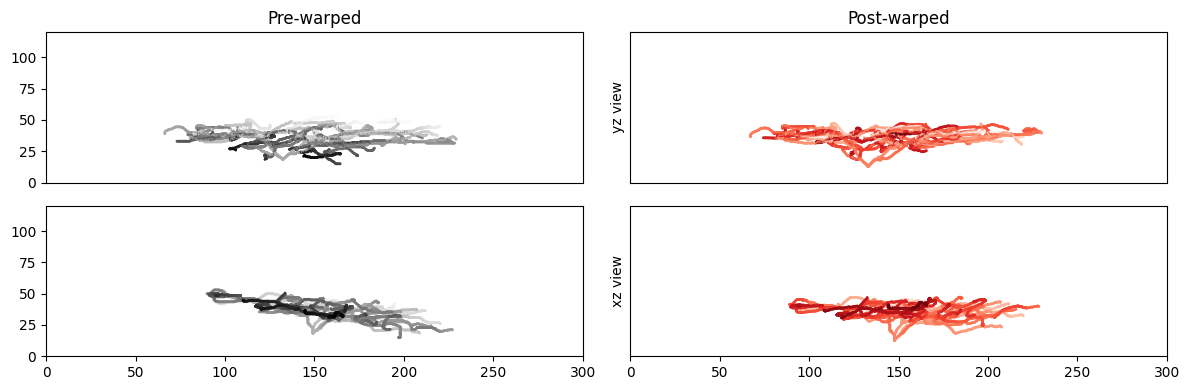

In [6]:
import matplotlib.pyplot as plt
mosaic = """
AB
CD
"""
fig, ax = plt.subplot_mosaic(mosaic=mosaic, figsize=(12, 4))

depth_order_pre = np.argsort(skel.nodes[:, 1])  # ascending (far → near)
sorted_nodes_pre = skel.nodes[depth_order_pre] * [0.4, 0.4, 0.5]  # scale to match the warped nodes

# Sort nodes for post-warped plot by depth (y-axis)
depth_order_post = np.argsort(warped_arbor.nodes[:, 1])
sorted_nodes_post = warped_arbor.nodes[depth_order_post]

# pre-warped
ax["A"].scatter(sorted_nodes_pre[:, 1], sorted_nodes_pre[:, 2], c=sorted_nodes_pre[:, 0], s=1, alpha=1, cmap="Grays")
ax["C"].scatter(sorted_nodes_pre[:, 0], sorted_nodes_pre[:, 2], c=sorted_nodes_pre[:, 1], s=1, alpha=1, cmap="Grays")
ax["A"].set_title("Pre-warped")

# post-warped
ax["B"].scatter(sorted_nodes_post[:, 1], sorted_nodes_post[:, 2], c=sorted_nodes_post[:, 0], s=1, alpha=1, cmap="Reds")
ax["D"].scatter(sorted_nodes_post[:, 0], sorted_nodes_post[:, 2], c=sorted_nodes_post[:, 1], s=1, alpha=1, cmap="Reds")

ax["B"].set_ylabel("yz view")
ax["D"].set_ylabel("xz view")

ax["B"].set_title("Post-warped")

for i in ["A", "B", "C", "D"]:

    if i not in ['C', 'D']:
        ax[i].set_xticks([])

    if i not in ['A', 'C']:
        ax[i].set_yticks([])

    ax[i].set_ylim(0, 120)
    ax[i].set_xlim(0, 300)

fig.tight_layout()

In [7]:
# z resolution (z_res) is needed to compute the z-profile, as the surface mapping is still in voxel units
normed_arbor = get_zprofile(warped_arbor, z_res=0.5, z_window=[-30, 30], nbins=120)

[skeliner] Warning: 58 nodes have zero radius; they were ignored when picking the estimator.


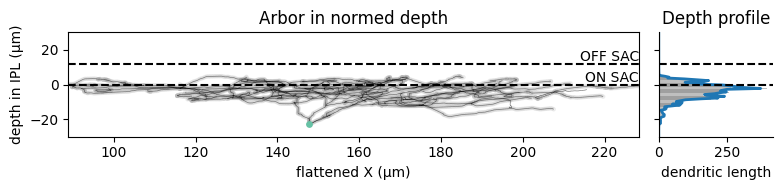

In [8]:
fig, (ax_nodes, ax_prof) = plt.subplots(
    1, 2,
    figsize=(8, 2),
    sharey=True,                 # align the y-axes
    gridspec_kw={'width_ratios': [5, 1]}
)

# --- left: flattened arbor ----------------------------------------
sk.plot2d(normed_arbor, plane="xz",
          ax=ax_nodes, color_by="ntype", skel_cmap="Set2",
          ylim=(-30, 30))
ax_nodes.set_xlabel('flattened X (µm)')
ax_nodes.set_ylabel('depth in IPL (µm)')
ax_nodes.set_title('Arbor in normed depth')

# guide lines at ON / OFF SAC
for y in (0, 12):
    ax_nodes.axhline(y, ls='--', c='k')
ax_nodes.text(ax_nodes.get_xlim()[1], 0,
              'ON SAC', va='bottom', ha='right', fontsize=10)
ax_nodes.text(ax_nodes.get_xlim()[1], 12,
              'OFF SAC', va='bottom', ha='right', fontsize=10)

zprofile = normed_arbor.extra["z_profile"]
z_dist = zprofile["z_dist"]
x = zprofile["z_x"]
z_hist = zprofile["z_hist"]
# --- right: depth profile (horizontal) ----------------------------
ax_prof.plot(z_dist, x, lw=2, c='tab:blue')
ax_prof.barh(x, z_hist, color="gray", alpha=0.5)
ax_prof.set_xlabel('dendritic length')
ax_prof.set_title('Depth profile')
ax_prof.axhline(0,  ls='--', c='k')
ax_prof.axhline(12, ls='--', c='k')

# remove unneeded spines to tidy the small panel
ax_prof.spines['top'].set_visible(False)
ax_prof.spines['right'].set_visible(False)

for ax in (ax_nodes, ax_prof):
    ax.set_aspect('auto') 

fig.tight_layout()
plt.show()

In [9]:
normed_arbor = get_xyprofile(
    normed_arbor, xy_window=[50, 250, 50, 250], nbins=20, sigma_bins=1
)

hull = get_convex_hull(normed_arbor.nodes[:, 0:2])
com_hull = get_hull_centroid(hull)

xy_profile = normed_arbor.extra["xy_profile"]
xy_x = xy_profile["xy_x"]
xy_y = xy_profile["xy_y"]
xy_dist = xy_profile["xy_dist"]
com_xy = get_xy_center_of_mass(xy_x, xy_y, xy_dist)

[skeliner] Warning: 58 nodes have zero radius; they were ignored when picking the estimator.


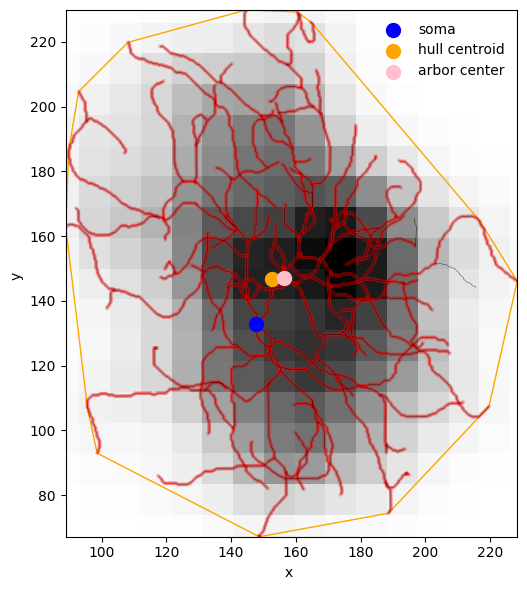

In [10]:
from matplotlib.colors import Normalize
fig, ax = plt.subplots(figsize=(6, 6))

im = ax.imshow(
    xy_dist.T, origin="lower",
    extent=[xy_x[0], xy_x[-1], xy_y[0], xy_y[-1]],
    cmap="Greys", norm=Normalize(vmin=0, vmax=xy_dist.max()),
)

sk.plot2d(
    normed_arbor, plane="xy", ax=ax,
)

ax.scatter(
    warped_arbor.nodes[0, 0],
    warped_arbor.nodes[0, 1],
    s=100, color='blue', zorder=99, label='soma',
)

ax.scatter(
    com_hull[0], com_hull[1],
    s=100, color='orange', zorder=99, label='hull centroid'
)

ax.scatter(
    com_xy[0], com_xy[1],
    s=100, color='pink', zorder=99, label='arbor center'
)

plt.fill(hull[:, 0], hull[:, 1], facecolor="none", edgecolor="orange", linewidth=1)

ax.legend(frameon=False)

In [11]:
%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark

Last updated: 2025-06-02 12:14:05CEST

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 9.1.0

pandas    : 2.2.3
pywarper  : 0.1.5
matplotlib: 3.10.3
numpy     : 2.0.2
skeliner  : 0.1.2

Watermark: 2.5.0

